# Moteur de recommandation de films : modélisation
## Initialisation
Important : le fichier de données doit se trouver dans le répertoire courant.


In [1]:
from IPython.display import display
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MultiLabelBinarizer
import sys
import warnings

pd.options.display.float_format = '{:,.3f}'.format
input_file = 'imdb.csv' # nom du fichier traité par le 1er notebook

print(f"Version de matplotlib : {matplotlib.__version__}")
print(f"Version de pandas : {pd.__version__}")
print(f"Version de Python : {sys.version}")

Version de matplotlib : 3.0.3
Version de pandas : 0.24.2
Version de Python : 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


### Chargement des données

In [2]:
data = pd.read_csv(input_file, delimiter='\t', keep_default_na=False)
print(f"Taille du tableau de données : {data.shape}")
print(f"Nombre de valeurs manquantes : {data.isnull().sum().sum()}")

Taille du tableau de données : (4847, 61)
Nombre de valeurs manquantes : 0


### Désignation de `id` comme index

In [3]:
data.set_index('id', inplace=True)

## Exploration sommaire
### Visualisation de la distribution des colonnes numériques

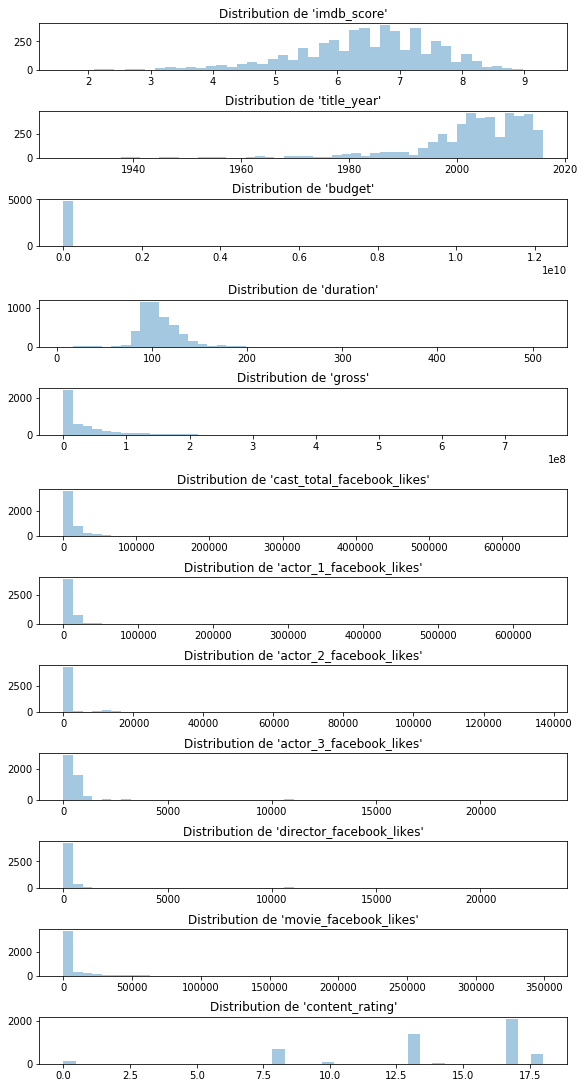

In [4]:
columns = ['imdb_score', 'title_year', 'budget', 
           'duration', 
           'gross', 
           'cast_total_facebook_likes',
           'actor_1_facebook_likes', 
           'actor_2_facebook_likes', 
           'actor_3_facebook_likes', 
           'director_facebook_likes',
           'movie_facebook_likes', 
           'content_rating']
n = len(columns)
fig, axes = plt.subplots(n, 1, figsize=(8, 15), constrained_layout=True)
for i, c in enumerate(columns):
    with warnings.catch_warnings():
        # https://github.com/mwaskom/seaborn/issues/1392    
        warnings.filterwarnings('ignore') 
        sns.distplot(a=data[c], ax=axes[i], kde=False, norm_hist=False)\
           .set_title(f"Distribution de '{c}'");
        axes[i].set_xlabel('');

### Contrôle du nombre de zéros par colonne

In [5]:
for c in columns:
    print(f"Nombre de 0 dans la colonne {c} : {sum(data[c] == 0)}")

Nombre de 0 dans la colonne imdb_score : 0
Nombre de 0 dans la colonne title_year : 0
Nombre de 0 dans la colonne budget : 456
Nombre de 0 dans la colonne duration : 0
Nombre de 0 dans la colonne gross : 799
Nombre de 0 dans la colonne cast_total_facebook_likes : 31
Nombre de 0 dans la colonne actor_1_facebook_likes : 31
Nombre de 0 dans la colonne actor_2_facebook_likes : 60
Nombre de 0 dans la colonne actor_3_facebook_likes : 100
Nombre de 0 dans la colonne director_facebook_likes : 946
Nombre de 0 dans la colonne movie_facebook_likes : 2118
Nombre de 0 dans la colonne content_rating : 122


### Distribution du pays et de la langue

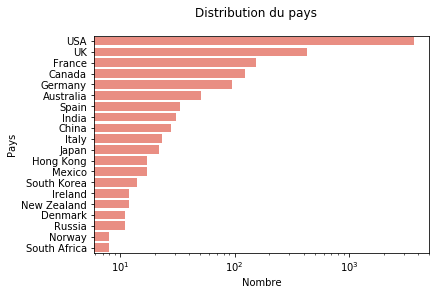

In [6]:
fig, axes = plt.subplots()
axes = sns.countplot(y="country", data=data, log=True, color='salmon',
                     order=data.country.value_counts().iloc[:20].index)
axes.set_xlabel("Nombre")
axes.set_ylabel("Pays")
fig.suptitle("Distribution du pays");

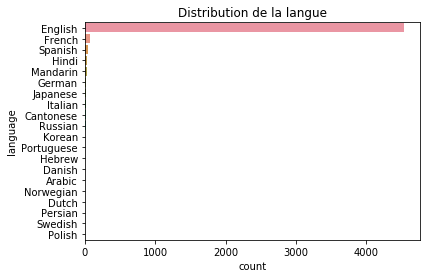

In [7]:
axes = sns.countplot(y="language", data=data, order=data.language.value_counts().iloc[:20].index)
axes.set_title("Distribution de la langue");

### Analyse de la corrélation entre colonnes numériques

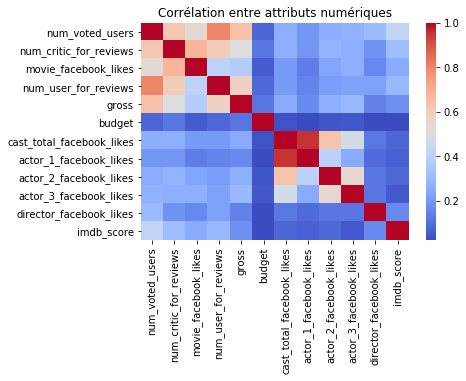

In [8]:
cols = ['num_voted_users',
        'num_critic_for_reviews', 
        'movie_facebook_likes', 
        'num_user_for_reviews', 
        'gross', 'budget', 
        'cast_total_facebook_likes',
        'actor_1_facebook_likes',
        'actor_2_facebook_likes',
        'actor_3_facebook_likes', 
        'director_facebook_likes',
        'imdb_score'
       ]
data_partial = data[cols]
corr = data_partial.corr()
axis = sns.heatmap(corr, cmap='coolwarm',
                   xticklabels=corr.columns.values,
                   yticklabels=corr.columns.values);
axis.set_title('Corrélation entre attributs numériques');

Conclusions : 
 - `num_voted_users` est fortement corrélé avec `num_critic_for_reviews`, `movie_facebook_likes`, `num_user_for_reviews` et `gross` ; nous pouvons donc ne conserver que ce premier attribut.
 - De même `cast_total_facebook_likes` est fortement corrélé avec `actor_1_facebook_likes`, que nous ignorerons.
 - Par cohérence et pour simplifier, nous ignorerons également `actor_2_facebook_likes` et `actor_3_facebook_likes`.

### Suppression des colonnes inutiles

In [9]:
drop_cols = ['num_critic_for_reviews', 
             'movie_facebook_likes',
             'num_user_for_reviews',
             'gross',
             'actor_1_facebook_likes',
             'actor_2_facebook_likes',
             'actor_3_facebook_likes']
data.drop(columns=drop_cols, errors='ignore', inplace=True)
# Supprime également la version normalisée
data.drop(columns=['adj_' + c for c in drop_cols], errors='ignore', inplace=True)

### Élimination des colonnes brutes, avant normalisation

In [10]:
# Liste des colonnes dont il existe une version normalisée
drop_cols = [c[4:] for c in data.columns if c.startswith('adj_')]
# Nous aurons besoin de `imdb_score`
if 'imdb_score' in drop_cols:
    drop_cols.remove('imdb_score')
data.drop(columns=drop_cols, errors='ignore', inplace=True)

### Sauvegarde de cette version compacte des données

In [11]:
data.to_csv('compact-'+input_file, sep='\t')

### Colonnes restantes autre que `genre_*`

In [12]:
[c for c in data.columns if not(c.startswith('genre_'))]

['director_name',
 'actor_2_name',
 'genres',
 'actor_1_name',
 'movie_title',
 'actor_3_name',
 'plot_keywords',
 'movie_imdb_link',
 'language',
 'country',
 'imdb_score',
 'adj_imdb_score',
 'adj_title_year',
 'adj_budget',
 'adj_director_facebook_likes',
 'adj_duration',
 'adj_cast_total_facebook_likes',
 'adj_content_rating',
 'adj_num_voted_users']

## Création d'une distance sur l'espace des films
### Méthode simple de mesure de distance entre 2 ensembles de mots-clefs

In [13]:
def dist_between_keywords(id1, id2):
    kw1 = set(data.loc[id1].plot_keywords.split('|'))
    kw2 = set(data.loc[id2].plot_keywords.split('|'))
    intersection = kw1.intersection(kw2)
    n = min(len(kw1), len(kw2))
    return (n - len(intersection)) / n

# Test, avec résultat attendu = 4 / 5 = 0.8
dist_between_keywords('tt0378407', 'tt0270980') 

0.8

### Liste des colonnes à considérer

In [14]:
# colonnes de genre
numeric_columns = [col for col in data if col.startswith('genre_')] 
# colonnes numériques (après normalisation)
numeric_columns.append('adj_budget') # petite ou grosse production
numeric_columns.append('adj_cast_total_facebook_likes') # popularité 
numeric_columns.append('adj_director_facebook_likes') # " du réalisateur
numeric_columns.append('adj_duration') # longueur
numeric_columns.append('adj_imdb_score') # note imdb
numeric_columns.append('adj_title_year') # époque du film
numeric_columns.append('adj_num_voted_users')
numeric_columns.append('adj_content_rating') # classification
# colonnes non numériques 
category_columns = ['director_name', 'country', 'language']
# colonnes à fusionner
set_columns = ['actor_1_name', 'actor_2_name', 'actor_3_name']
# colonne de mots-clefs
keyword_column = 'plot_keywords'

### Fonction de calcul de distance

In [15]:
def dist1(id1, id2, metric):
    """Calcule la distance (euclidienne par défaut) entre 2 films."""
    film1 = data.loc[id1]
    film2 = data.loc[id2]
    n = len(numeric_columns) + len(category_columns) + 2
    v1 = np.zeros(n).reshape(1, n)
    v2 = np.zeros(n).reshape(1, n)
    # pour les attributs numériques, pas de changement
    for i, col in enumerate(numeric_columns):
        v1[0, i] = film1[col]
        v2[0, i] = film2[col]
    # teste l'égalité des attributs catégoriels
    for i, col in enumerate(category_columns):
        v2[0, len(numeric_columns)+i] = 0 if film1[col] == film2[col] else 1    
    # calcule le nb d'éléments communs aux 2 ensembles
    set1 = { film1[col] for col in set_columns }
    set2 = { film2[col] for col in set_columns }
    size = len(set1)
    v2[0, n-2] = (size - len(set1.intersection(set2))) / size
    # calcule le nombre de mots-clefs communs
    v2[0, n-1] = dist_between_keywords(id1, id2)
    return pairwise_distances(v1, v2, metric=metric)[0][0]

# test de validité
print(dist1('tt0068646','tt0099685', 'euclidean'))

2.004207682298129


### Application à la distance euclidienne

In [16]:
movies = ['tt0068646', # The Godfather 
          'tt0071562', # The Godfather II
          'tt0099685', # Goodfellas
          'tt0110912', # Pulp Fiction
          'tt0072271', # The Texas Chainsaw Massacre
          'tt0083907', # Evil Dead
          'tt0084516', # Poltergeist
          'tt0387564', # Saw
          'tt0114709', # Toy Story
          'tt0435761', # Toy Story 3
          'tt0266543', # Finding Nemo
          'tt0382932'] # Ratatouille
distances = pd.DataFrame(index=movies, columns=movies, dtype=float)
for x in movies:
    for y in movies:
        distances.loc[x, y] = dist1(x, y, 'euclidean')
distances

,tt0068646,tt0071562,tt0099685,tt0110912,tt0072271,tt0083907,tt0084516,tt0387564,tt0114709,tt0435761,tt0266543,tt0382932
tt0068646,0.000,1.080,2.004,1.886,2.730,2.724,2.774,2.903,3.333,3.352,3.181,3.200
tt0071562,1.080,0.000,2.012,1.908,2.695,2.690,2.737,2.876,3.323,3.337,3.173,3.182
tt0099685,2.004,2.012,0.000,2.033,2.954,2.950,2.990,3.107,3.526,3.536,3.383,3.386
tt0110912,1.886,1.908,2.033,0.000,2.845,2.835,2.879,2.983,3.401,3.412,3.244,3.261
tt0072271,2.730,2.695,2.954,2.845,0.000,2.238,2.064,2.032,3.325,3.337,3.182,3.176
tt0083907,2.724,2.690,2.950,2.835,2.238,0.000,1.804,2.465,3.001,3.010,3.172,2.832
tt0084516,2.774,2.737,2.990,2.879,2.064,1.804,0.000,2.515,2.886,2.894,3.063,2.707
tt0387564,2.903,2.876,3.107,2.983,2.032,2.465,2.515,0.000,3.456,3.453,3.309,3.302
tt0114709,3.333,3.323,3.526,3.401,3.325,3.001,2.886,3.456,0.000,1.336,2.003,1.865
tt0435761,3.352,3.337,3.536,3.412,3.337,3.010,2.894,3.453,1.336,0.000,2.004,1.857


On note une association surprenante pour le dernier film ! Étant donné la taille réduite du jeu de données, nous ne nous en inquiétons pas. 

### Représentation graphique des distances 2 à 2

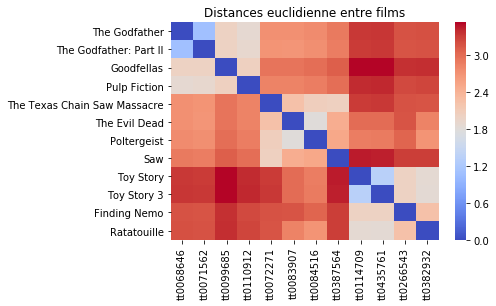

In [17]:
fig, axes = plt.subplots(1, 1);
sns.heatmap(data=distances, cmap='coolwarm', ax=axes);
axes.set_title('Distances euclidienne entre films');
axes.set_yticklabels(data.loc[movies, 'movie_title'].tolist());

### Application à la distance cosinus

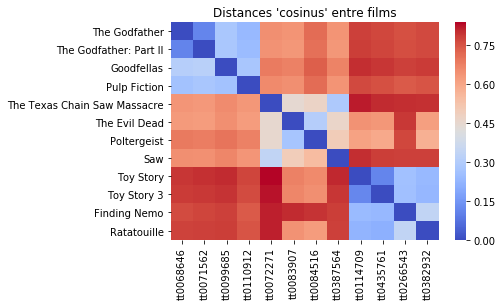

In [18]:
for x in movies:
    for y in movies:
        distances.loc[x, y] = dist1(x, y, 'cosine')
fig, axes = plt.subplots(1, 1);
sns.heatmap(data=distances, cmap='coolwarm', ax=axes);
axes.set_title("Distances 'cosinus' entre films");
axes.set_yticklabels(data.loc[movies, 'movie_title'].tolist());

### Identification des 3 points les plus proches d'un point donné

In [19]:
order = np.argsort(distances, axis=1) 
sorted = pd.DataFrame(distances.columns[order], distances.index)
sorted = sorted.applymap(lambda id : data.loc[id, 'movie_title'])
for i, row in sorted.iterrows():
    print(row[0] + "  ->  " + row[1] + ", " + row[2] + ", " + row[3])

The Godfather  ->  The Godfather: Part II, Pulp Fiction, Goodfellas
The Godfather: Part II  ->  The Godfather, Pulp Fiction, Goodfellas
Goodfellas  ->  Pulp Fiction, The Godfather, The Godfather: Part II
Pulp Fiction  ->  The Godfather, Goodfellas, The Godfather: Part II
The Texas Chain Saw Massacre  ->  Saw, The Evil Dead, Poltergeist
The Evil Dead  ->  Poltergeist, The Texas Chain Saw Massacre, Saw
Poltergeist  ->  The Evil Dead, The Texas Chain Saw Massacre, Saw
Saw  ->  The Texas Chain Saw Massacre, The Evil Dead, Poltergeist
Toy Story  ->  Toy Story 3, Ratatouille, Finding Nemo
Toy Story 3  ->  Toy Story, Ratatouille, Finding Nemo
Finding Nemo  ->  Toy Story 3, Toy Story, Ratatouille
Ratatouille  ->  Toy Story 3, Toy Story, Finding Nemo


Ces résultats sont très satisfaisants, mais, étant donné la faible taille de l'espace considéré, on ne peut guère en tirer de conclusions.

## Partionnement ('clustering') de l'espace des films
### Création d'un sous-tableau de données

In [20]:
cols = [col for col in data if col.startswith('genre_')]
#cols.extend(['adj_duration', 'adj_num_voted_users',
#             'adj_cast_total_facebook_likes',
#             'adj_content_rating', 'adj_title_year', 
#             'adj_imdb_score', 'adj_budget']) 
cols.extend(['adj_content_rating', 'adj_title_year', 'adj_imdb_score'])
X = data[cols]
print(f"Nombre de colonnes : {len(cols)}")

Nombre de colonnes : 25


### Préparation des indicateurs de mots-clefs
#### Création de la matrice d'indicateurs

Nombre de mots-clefs : 8043
Nb de mots-clefs avec plus de 5 films: 782
Nb de mots-clefs avec plus de 10 films: 371
Nb de mots-clefs avec plus de 15 films: 228
Nb de mots-clefs avec plus de 20 films: 152


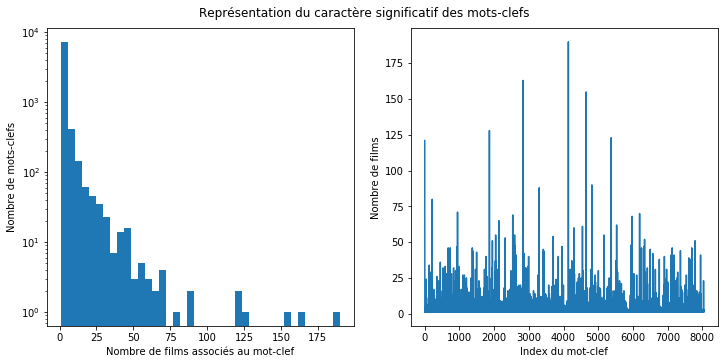

In [21]:
cv = CountVectorizer(tokenizer=lambda s: s.split("|"))
plot_kw = cv.fit_transform(data['plot_keywords']).todense()
plot_kw_list = ['kw_' + kw.replace(' ', '_') for kw in cv.get_feature_names()]
print(f"Nombre de mots-clefs : {len(plot_kw_list)}")
subtotals = np.squeeze(np.asarray(plot_kw.sum(axis=0)))
for n in range(5, 25, 5):
    print(f"Nb de mots-clefs avec plus de {n} films: {sum(subtotals > n)}")
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
axes[0].hist(subtotals, bins=40);
axes[0].set_xlabel('Nombre de films associés au mot-clef')
axes[0].set_ylabel('Nombre de mots-clefs')
axes[0].set_yscale('log')
axes[1].plot(subtotals);
axes[1].set_xlabel('Index du mot-clef');
axes[1].set_ylabel('Nombre de films');
fig.suptitle('Représentation du caractère significatif des mots-clefs');

Commentaires : 1) peu d'info 2) variable binaire donc pas idéale pour K-means.

#### Suppression de la colonne indiquant l'absence de mot-clef
En effet il n'y a aucune similarité entre les films appartenant à cette catégorie.

In [22]:
key = 'kw_' # Indique l'absence de mot-clef
if key in plot_kw_list:
    print(f"Taille de la matrice avant suppression : {plot_kw.shape}")
    pos = plot_kw_list.index(key)
    print(f"Index de la colonne à effacer : {pos}")
    plot_kw = np.delete(plot_kw, pos, axis=1)
    plot_kw_list.remove(key)
    print(f"Taille de la matrice après suppression : {plot_kw.shape}")

Taille de la matrice avant suppression : (4847, 8043)
Index de la colonne à effacer : 0
Taille de la matrice après suppression : (4847, 8042)


### Réduction de dimensionnalité par seuil de variance

Variance min. = 0.00020627061828276368, variance max. = 0.03766290366800544


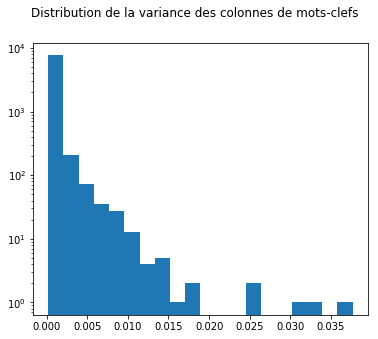

In [23]:
selector = VarianceThreshold()
selector.fit_transform(plot_kw)
v = selector.variances_
fig, axes = plt.subplots(1, 1, figsize=(6, 5))
axes.hist(v, bins=20, log=True);
fig.suptitle("Distribution de la variance des colonnes de mots-clefs")
print(f"Variance min. = {min(v)}, variance max. = {max(v)}")

Nous pourrions procéder à une réduction de dimension en supprimant les colonnes avec la variance la plus faible, car leur pouvoir prédictif sera limité. Nous fixons initialement le seuil d'exclusion à 20% de la variance maximale.

In [24]:
def variance_threshold_selector(matrix, labels, threshold):
    selector = VarianceThreshold(threshold)
    selector.fit(matrix)
    col_indices = selector.get_support(indices=True)
    print(f"Nombre de colonnes retenues : {len(col_indices)}")
    names = [labels[i] for i in col_indices]
    return pd.DataFrame(matrix[:, col_indices], columns=names, index=data.index)
# Test avec résultat attendu : 0, 1, 0
variance_threshold_selector(plot_kw, plot_kw_list, 0.03).loc['tt0036868', :]

Nombre de colonnes retenues : 3


kw_friend    0
kw_love      1
kw_murder    0
Name: tt0036868, dtype: int64

In [25]:
variance_threshold = max(v) * 0.2
df_plot_kw = variance_threshold_selector(plot_kw, plot_kw_list, variance_threshold)
df_plot_kw

Nombre de colonnes retenues : 60


,kw_alien,kw_battle,kw_best_friend,kw_box_office_flop,kw_boy,kw_christmas,kw_cia,kw_college,kw_cult_film,kw_death,...,kw_teacher,kw_teenager,kw_terrorist,kw_texas,kw_train,kw_vampire,kw_violence,kw_vomiting,kw_wedding,kw_writer
id,,,,,,,,,,,,,,,,,,,,,
tt5574490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5215952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
tt5116280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5078326,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt5001130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4939066,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4877736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4871980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tt4824308,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Amélioration : mesure de la fréquence d'apparition des mots-clefs
Application à la matrice non normalisée d'apparition des mots-clefs (produite par `CountVectorizer`).

In [26]:
fv = TfidfVectorizer(tokenizer=lambda s: s.split("|"))
plot_kw_freq = fv.fit_transform(data['plot_keywords']).todense()
plot_kw_freq_list = ['kw_' + kw.replace(' ', '_') for kw in fv.get_feature_names()]
key_to_delete = 'kw_'
if key_to_delete in plot_kw_freq_list:
    pos = plot_kw_freq_list.index(key_to_delete)
    plot_kw_freq = np.delete(plot_kw_freq, pos, axis=1)
    plot_kw_freq_list.remove(key_to_delete)
print(f"Égalité des 2 listes de mots-clefs : {plot_kw_list == plot_kw_freq_list}")

Égalité des 2 listes de mots-clefs : True


Valeur maximale de TF-IDF pour le film : Luther


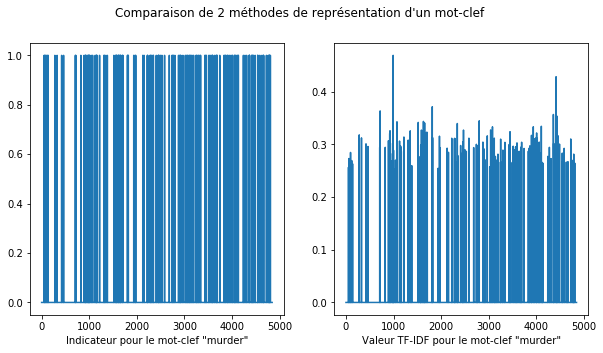

In [27]:
col = plot_kw_freq_list.index('kw_murder')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(plot_kw[:, col]);
axes[0].set_xlabel('Indicateur pour le mot-clef "murder"')
axes[1].plot(plot_kw_freq[:, col]);
axes[1].set_xlabel('Valeur TF-IDF pour le mot-clef "murder"');
fig.suptitle("Comparaison de 2 méthodes de représentation d'un mot-clef")
max_index = np.argmax(plot_kw_freq[:, col])
print(f"Valeur maximale de TF-IDF pour le film : {data['movie_title'][max_index]}")

### Réduction de dimensionnalité par ACP
Application à la matrice normalisée (TF-IDF).
#### Analyse sans réduction du nombre de composants

In [28]:
pca = PCA()
pca.fit(plot_kw_freq);

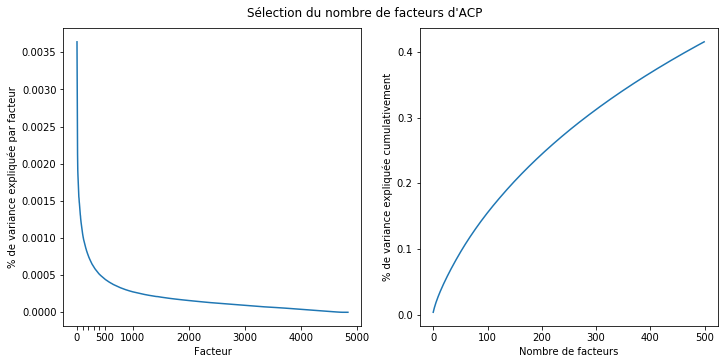

In [29]:
variances = pca.explained_variance_ratio_
ev = pca.singular_values_ # valeurs propres
fig, ax = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.suptitle("Sélection du nombre de facteurs d'ACP")
# Premier graphe avec tous les facteurs
ax[0].plot(ev**2 / sum(ev**2));
ax[0].set_xlabel('Facteur');
ax[0].set_ylabel('% de variance expliquée par facteur');
ax[0].set_xticks([0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000])
ax[0].set_xticklabels([0, '', '', '', '', 500, 1000, 2000, 3000, 4000, 5000])
# Gros plan sur les facteurs plus gros contributeurs
ax[1].plot(np.cumsum(ev[0:500]**2 / sum(ev**2)));
ax[1].set_xlabel('Nombre de facteurs');
ax[1].set_ylabel('% de variance expliquée cumulativement');

Le premier graphique confirme qu'au-delà une centaine de facteurs, l'explication de variance par les facteurs suivants est très faible. Malheureusement le deuxième graphe montre qu'avec 150 facteurs on n'explique qu'environ 20% de la variance totale.

#### Calibration d'un modèle d'ACP avec un nombre réduit de dimensions

In [30]:
dims = 150
pca = PCA(n_components=dims)
plot_kw_pca = pca.fit_transform(plot_kw_freq);
print(f"Dimension de la matrice de mots-clefs après ACP : {plot_kw_pca.shape}")

Dimension de la matrice de mots-clefs après ACP : (4847, 150)


#### Vérification manuelle
Il n'y a rien de très rigoureux dans ce qui suit, nous cherchons juste à nous convaincre en examinant un exemple simple que le changement de base est effectué correctement.

Code du film : tt1666186
Mots-clefs : kw_friend, kw_love
Position des 2 mots-clefs : 2834, 4139
Poids dans 1er vecteur ACP : 0.5747781027074116, 0.6316528641242574
Coefficients de kw1 et kw2 : 0.36604251407198, 0.3533243988165561
Première coordonnée dans la nouvelle base : 0.4455556697579658


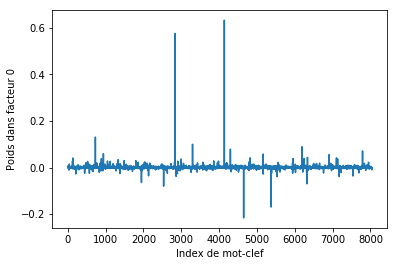

In [31]:
factor = 0
ev = pca.components_[factor, :] # Facteur choisi
coeff_loc = np.where(ev >= 0.3) 
kw1 = coeff_loc[0][0] # 1er coeff non négligeable
kw2 = coeff_loc[0][1] # 2e coeff non négligeable
movie = 785 # Film choisi pour avoir ces 2 mots-clefs
fig, axes = plt.subplots()
axes.plot(ev)
axes.set_xlabel('Index de mot-clef')
axes.set_ylabel(f'Poids dans facteur {factor}')
print(f"Code du film : {data.index[movie]}")
print(f"Mots-clefs : {plot_kw_list[kw1]}, {plot_kw_list[kw2]}")
print(f"Position des 2 mots-clefs : {kw1}, {kw2}")
print(f"Poids dans 1er vecteur ACP : {ev[kw1]}, {ev[kw2]}")
print(f"Coefficients de kw1 et kw2 : {plot_kw_freq[movie, kw1]}, {plot_kw_freq[movie, kw2]}")
# Valeur attendue approximativement : 
#- environ 1.2 on utilise CountVectorizer
#- environ 0.45 si on utilise TF-IDF
print(f"Première coordonnée dans la nouvelle base : {plot_kw_pca[movie, 0]}")

#### Ajout au tableau de données

In [32]:
pca_cols = [ 'ACP' + str(c) for c in list(range(0, dims))]
df_kw = pd.DataFrame(plot_kw_pca, columns=pca_cols, index=X.index)
X1 = pd.concat([X, df_kw], axis=1)
print(f"Taille du tableau de données : {X1.shape}")
# Vérification - valeurs attendues : 0.35, 1.2 ou 0.45
X1.loc['tt1666186', ['adj_imdb_score', 'ACP0']] 

Taille du tableau de données : (4847, 175)


adj_imdb_score   0.350
ACP0             0.446
Name: tt1666186, dtype: float64

### Ajout du nom du réalisateur

Nombre de réalisateurs : 2347
Nombre de réalisateurs avec plus de 10 films: 27


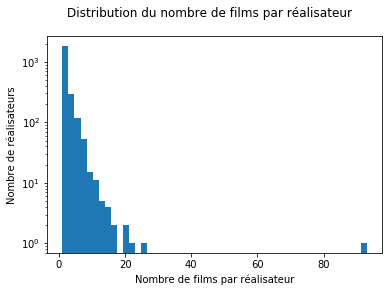

In [33]:
directors = data['director_name'].value_counts().sort_values(ascending=False)
print(f"Nombre de réalisateurs : {len(directors)}")
print(f"Nombre de réalisateurs avec plus de 10 films: {sum(directors > 10)}")
fig, axes = plt.subplots()
directors.hist(bins=50, ax=axes, log=True, grid=False);
fig.suptitle("Distribution du nombre de films par réalisateur");
axes.set_xlabel("Nombre de films par réalisateur")
axes.set_ylabel("Nombre de réalisateurs");

Nous retenons donc les 30 premiers réalisateurs, les suivants n'ayant pas assez de films pour nous permettre d'établir des rapprochements entre films.

In [34]:
n_directors = 30
cv = CountVectorizer(tokenizer=lambda s: s.split("|"), 
                     max_features=n_directors)
directors = cv.fit_transform(data['director_name'])
director_list = ['dir_' + d.replace(' ', '_') for d in cv.get_feature_names()]
print(f"Taille de la matrice de réalisateurs : {directors.shape}")
df_directors = pd.DataFrame(directors.todense(), 
                            columns=director_list, index=X.index)
X2 = pd.concat([X1, df_directors], axis=1)
print(f"Nouvelle taille du tableau de données : {X2.shape}")
# Vérification - valeurs attendues : 0.92, 0, 1
X2.loc['tt0068646', ['adj_imdb_score', 
                     'dir_steven_spielberg', 
                     'dir_francis_ford_coppola']]

Taille de la matrice de réalisateurs : (4847, 30)
Nouvelle taille du tableau de données : (4847, 205)


adj_imdb_score             0.920
dir_steven_spielberg       0.000
dir_francis_ford_coppola   1.000
Name: tt0068646, dtype: float64

### Ajout du pays
Étant donnée la distribution de la variable `country` (voir plus haut), nous ne retenons que les 12 valeurs les plus courantes.

In [35]:
n_countries = 12
cv = CountVectorizer(tokenizer=lambda s: s.split("|"), max_features=n_countries)
countries = cv.fit_transform(data['country'])
country_list = ['country_' + d.replace(' ', '_') for d in cv.get_feature_names()]
print("Liste des colonnes de pays :", ", ".join(country_list))
print(f"Taille de la matrice de pays : {countries.shape}")
df_countries = pd.DataFrame(countries.todense(), columns=country_list, index=X.index)
X3 = pd.concat([X2, df_countries], axis=1)
print(f"Nouvelle taille du tableau de données : {X3.shape}")
# Vérification - valeurs attendues : 0.82, 0, 1
X3.loc['tt4262980', ['adj_imdb_score', 'country_germany', 'country_japan']]

Liste des colonnes de pays : country_australia, country_canada, country_china, country_france, country_germany, country_hong_kong, country_india, country_italy, country_japan, country_spain, country_uk, country_usa
Taille de la matrice de pays : (4847, 12)
Nouvelle taille du tableau de données : (4847, 217)


adj_imdb_score    0.820
country_germany   0.000
country_japan     1.000
Name: tt4262980, dtype: float64

Afin de limiter la taille du tableau de données, nous renonçons à créer des colonnes indicatrices des acteurs et de la langue.
### Optimisation du nombre de partitions

In [36]:
n_clusters_vals = [40, 60, 80, 100, 150, 200, 300, 400, 500]
for n_clusters in n_clusters_vals:
    np.random.seed(42) # Rend les résultats reproductibles
    model = KMeans(n_clusters=n_clusters)
    categories = model.fit_predict(X3)
    sil_avg = silhouette_score(X3, categories)
    min_count = min(pd.DataFrame(categories, columns=['category'])['category'].value_counts())
    print(f"Avec {n_clusters} partitions, score de silhouette moyen = "
          f"{sil_avg:0.2f}, taille minimale = {min_count}.")

Avec 40 partitions, score de silhouette moyen = 0.12, taille minimale = 42.
Avec 60 partitions, score de silhouette moyen = 0.15, taille minimale = 16.
Avec 80 partitions, score de silhouette moyen = 0.16, taille minimale = 15.
Avec 100 partitions, score de silhouette moyen = 0.16, taille minimale = 2.
Avec 150 partitions, score de silhouette moyen = 0.18, taille minimale = 3.
Avec 200 partitions, score de silhouette moyen = 0.18, taille minimale = 1.
Avec 300 partitions, score de silhouette moyen = 0.17, taille minimale = 1.
Avec 400 partitions, score de silhouette moyen = 0.17, taille minimale = 1.
Avec 500 partitions, score de silhouette moyen = 0.17, taille minimale = 1.


Pour la version pilote de notre outil de recommandation, nous retenons la valeur n_clusters = 100. Avec des valeurs supérieures on obtient un meilleur score de silhouette moyen, mais une taille minimale de partition trop faible.

Nous notons que le score de silhouette atteint est faible, mais meilleur que lorsque nous avions utilisé les indicateurs de mots-clefs non normalisés. Sa valeur maximale était alors 0,10.
### Calibration finale du modèle

In [37]:
n_clusters = 80
model = KMeans(n_clusters=n_clusters, random_state=42)
categories = model.fit_predict(X3)
df_categories = pd.DataFrame(categories, index=data.index, columns=['category'])
print(f"Taille du tableau de catégories : {df_categories.shape}")
df_categories.to_csv('categories.csv', sep='\t')

Taille du tableau de catégories : (4847, 1)


### Distribution des tailles de catégories

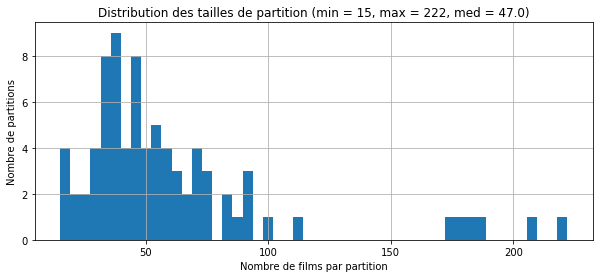

In [38]:
sizes = df_categories['category'].value_counts()
fig, axes = plt.subplots(figsize=(10, 4))
sizes.hist(bins=50, ax=axes);
axes.set_title(f"Distribution des tailles de partition (min = {sizes.min()}, "
               f"max = {sizes.max()}, med = {np.median(sizes)})");
axes.set_xlabel("Nombre de films par partition");
axes.set_ylabel("Nombre de partitions");

Nous observons que tous les clusters ont une taille satisfaitante (jamais < 5).
## Exploitation des partitions pour faire des recommandations
### Liste des films dans la catégorie de Toy Story

In [39]:
id = 'tt0114709' # Toy Story
cat = df_categories.loc[id, 'category']
print(f"Index de la partition : {cat}")
print(f"Nombre de films dans la partition : {sum(df_categories['category']==cat)}")
cols = ['movie_title', 'genres', 'plot_keywords', 'imdb_score']
data.loc[df_categories['category']==cat, cols]\
    .sort_values(by='imdb_score', ascending=False)

Index de la partition : 16
Nombre de films dans la partition : 75


,movie_title,genres,plot_keywords,imdb_score
id,,,,
tt0114709,Toy Story,Adventure|Animation|Comedy|Family|Fantasy,claw crane|cowboy|jealousy|rivalry|toy,8.300
tt0435761,Toy Story 3,Adventure|Animation|Comedy|Family|Fantasy,college|day care|escape|teddy bear|toy,8.300
tt2096673,Inside Out,Adventure|Animation|Comedy|Drama|Family|Fantasy,anger|joy|memory|running away|sadness,8.300
tt0892769,How to Train Your Dragon,Adventure|Animation|Family|Fantasy,dragon|island|training|viking|village,8.200
tt0198781,"Monsters, Inc.",Adventure|Animation|Comedy|Family|Fantasy,friend|little girl|monster|rival|scream,8.100
tt0382932,Ratatouille,Animation|Comedy|Family|Fantasy,chef|food|french|rat|restaurant,8.000
tt1646971,How to Train Your Dragon 2,Action|Adventure|Animation|Comedy|Family|Fantasy,dragon|father son relationship|husband wife re...,7.900
tt0120363,Toy Story 2,Adventure|Animation|Comedy|Family|Fantasy,collector|dog|friend|rescue|toy,7.900
tt0126029,Shrek,Adventure|Animation|Comedy|Family|Fantasy,donkey|fairy tale|ogre|princess|swamp,7.900


### Liste des films dans la catégorie de The Witch

In [40]:
def format_pairs(mylist):
    pairs = zip(mylist[::2], mylist[1::2])
    return '\n'.join(f"{s[0]:<70}{s[1]}" for s in pairs)

id = 'tt4263482' # The Witch
cat = df_categories.loc[id, 'category']
print(f"Index de la partition : {cat}")
print(f"Nombre de films : {sum(df_categories['category']==cat)}")
print("Liste de films :\n")
movies = data.loc[df_categories['category']==cat, 'movie_title'].to_list()
print(format_pairs(movies))

Index de la partition : 45
Nombre de films : 39
Liste de films :

The Witch                                                             Housebound
Annabelle                                                             It Follows
Devil's Due                                                           Oculus
Sinister                                                              Truth or Die
Absentia                                                              The Mortal Instruments: City of Bones
Scream 4                                                              Sorority Row
Saw V                                                                 Prom Night
Saw IV                                                                The Midnight Meat Train
Mirrors                                                               Saw III
One Missed Call                                                       Saw II
The Eye                                                               The Ring Two
Jeepers 

### Création d'une fonction de recommandation
Une fois la partition du film identifiée, nous sélectionnons les n films avec le meilleur score ou les plus proches du film spécifié.

In [41]:
def get_best_movies_in_cluster(id, n=5, sort_by='imdb_score'):
    cat = df_categories.loc[id, 'category']
    mask = (df_categories['category'] == cat) & (data.index != id)
    shortlist = data.loc[mask, ['movie_title', 'genres', 
                                'plot_keywords', 'imdb_score']]
    # Calcul de la distance
    dist = lambda movie: dist1(movie, id, 'cosine')
    shortlist['dist'] = shortlist.index.to_series().apply(dist)
    shortlist['cluster'] = cat
    # Tri des résultats 
    sort_asc = False if sort_by == 'imdb_score' else True
    shortlist.sort_values(by=sort_by, ascending=sort_asc, inplace=True)
    return shortlist.iloc[0:n, :]

### Application aux exemples précédents
#### Recommandations avec les meilleurs scores

In [42]:
get_best_movies_in_cluster('tt0068646', 5, 'imdb_score') # The Godfather

,movie_title,genres,plot_keywords,imdb_score,dist,cluster
id,,,,,,
tt0111161,The Shawshank Redemption,Crime|Drama,escape from prison|first person narration|pris...,9.300,0.233,57
tt0071562,The Godfather: Part II,Crime|Drama,1950s|corrupt politician|lake tahoe nevada|mel...,9.000,0.108,57
tt0050083,12 Angry Men,Crime|Drama,courtroom|dialogue driven|dialogue driven stor...,8.900,0.242,57
tt0110912,Pulp Fiction,Crime|Drama,black comedy|cunnilingus|neo noir|nonlinear ti...,8.900,0.263,57
tt0317248,City of God,Crime|Drama,coming of age|male frontal nudity|male nudity|...,8.700,0.328,57


In [43]:
get_best_movies_in_cluster('tt0114709', 5, 'imdb_score') # Toy Story

,movie_title,genres,plot_keywords,imdb_score,dist,cluster
id,,,,,,
tt0435761,Toy Story 3,Adventure|Animation|Comedy|Family|Fantasy,college|day care|escape|teddy bear|toy,8.300,0.116,16
tt2096673,Inside Out,Adventure|Animation|Comedy|Drama|Family|Fantasy,anger|joy|memory|running away|sadness,8.300,0.243,16
tt0892769,How to Train Your Dragon,Adventure|Animation|Family|Fantasy,dragon|island|training|viking|village,8.200,0.256,16
tt0198781,"Monsters, Inc.",Adventure|Animation|Comedy|Family|Fantasy,friend|little girl|monster|rival|scream,8.100,0.149,16
tt0382932,Ratatouille,Animation|Comedy|Family|Fantasy,chef|food|french|rat|restaurant,8.000,0.220,16


In [44]:
get_best_movies_in_cluster('tt0029583', 5, 'imdb_score') # Snow White

,movie_title,genres,plot_keywords,imdb_score,dist,cluster
id,,,,,,
tt0110357,The Lion King,Adventure|Animation|Drama|Family|Musical,king|prince|scar|uncle|unnecessary guilt,8.500,0.471,67
tt0032138,The Wizard of Oz,Adventure|Family|Fantasy|Musical,evil witch|tornado|witch|wizard|wizard of oz,8.100,0.370,67
tt0103639,Aladdin,Adventure|Animation|Comedy|Family|Fantasy|Musi...,arab|genie|magic|princess|reference to a thous...,8.000,0.400,67
tt0067992,Willy Wonka & the Chocolate Factory,Family|Fantasy|Musical,candy|chocolate|factory|miniaturization|sudden...,7.800,0.336,67
tt0398286,Tangled,Adventure|Animation|Comedy|Family|Fantasy|Musi...,17th century|based on fairy tale|disney|flower...,7.800,0.400,67


#### Recommandations des films les plus similaires

In [45]:
get_best_movies_in_cluster('tt0068646', 5, 'dist') # The Godfather

,movie_title,genres,plot_keywords,imdb_score,dist,cluster
id,,,,,,
tt0071562,The Godfather: Part II,Crime|Drama,1950s|corrupt politician|lake tahoe nevada|mel...,9.000,0.108,57
tt0099674,The Godfather: Part III,Crime|Drama,1970s|family relationships|mob hit|opera|repea...,7.600,0.161,57
tt0086250,Scarface,Crime|Drama,assassination attempt|capitalism|cocaine|cuban...,8.300,0.207,57
tt0086066,The Outsiders,Crime|Drama,dysfunctional family|gang|greaser|holding some...,7.200,0.214,57
tt0056592,To Kill a Mockingbird,Crime|Drama,1930s|alabama|lawyer|six year old|trial,8.400,0.223,57


In [46]:
get_best_movies_in_cluster('tt0114709', 5, 'dist') # Toy Story

,movie_title,genres,plot_keywords,imdb_score,dist,cluster
id,,,,,,
tt0120363,Toy Story 2,Adventure|Animation|Comedy|Family|Fantasy,collector|dog|friend|rescue|toy,7.900,0.055,16
tt0120623,A Bug's Life,Adventure|Animation|Comedy|Family|Fantasy,ant|circus|grasshopper|misunderstanding|overhe...,7.200,0.102,16
tt0435761,Toy Story 3,Adventure|Animation|Comedy|Family|Fantasy,college|day care|escape|teddy bear|toy,8.300,0.116,16
tt0198781,"Monsters, Inc.",Adventure|Animation|Comedy|Family|Fantasy,friend|little girl|monster|rival|scream,8.100,0.149,16
tt1217209,Brave,Adventure|Animation|Comedy|Family|Fantasy,archery|coming of age|female warrior|princess|...,7.200,0.168,16


In [47]:
get_best_movies_in_cluster('tt0029583', 5, 'dist') # Snow White

,movie_title,genres,plot_keywords,imdb_score,dist,cluster
id,,,,,,
tt0032910,Pinocchio,Animation|Family|Fantasy|Musical,boy|conscience|fairy|jiminy cricket|pinocchio,7.500,0.211,67
tt0884726,Legends of Oz: Dorothy's Return,Adventure|Animation|Family|Fantasy|Musical,jester|kansas|oz|princess|tornado,5.600,0.313,67
tt0350194,Teacher's Pet,Animation|Comedy|Family|Fantasy|Musical,dog|florida|mad scientist|school|teacher,5.800,0.320,67
tt0118829,Cats Don't Dance,Animation|Comedy|Family|Fantasy|Musical,animal|cat|child star|hollywood|star,6.900,0.334,67
tt0067992,Willy Wonka & the Chocolate Factory,Family|Fantasy|Musical,candy|chocolate|factory|miniaturization|sudden...,7.800,0.336,67


## Visualisation des partitions

In [48]:
tsne = TSNE(n_components=2, verbose=1, n_iter=5000, perplexity=70)
tsne_results = tsne.fit_transform(X3)
print(f"Taille du tableau en sortie : {tsne_results.shape}")

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 4847 samples in 0.165s...
[t-SNE] Computed neighbors for 4847 samples in 13.995s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4847
[t-SNE] Computed conditional probabilities for sample 2000 / 4847
[t-SNE] Computed conditional probabilities for sample 3000 / 4847
[t-SNE] Computed conditional probabilities for sample 4000 / 4847
[t-SNE] Computed conditional probabilities for sample 4847 / 4847
[t-SNE] Mean sigma: 0.521535
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.500404
[t-SNE] KL divergence after 5000 iterations: 0.944568
Taille du tableau en sortie : (4847, 2)


In [49]:
title_col = data.columns.get_loc('movie_title')
names = [data[categories==i].iloc[0, title_col] + f" ({sum(categories==i)})"\
         for i in range(n_clusters)]

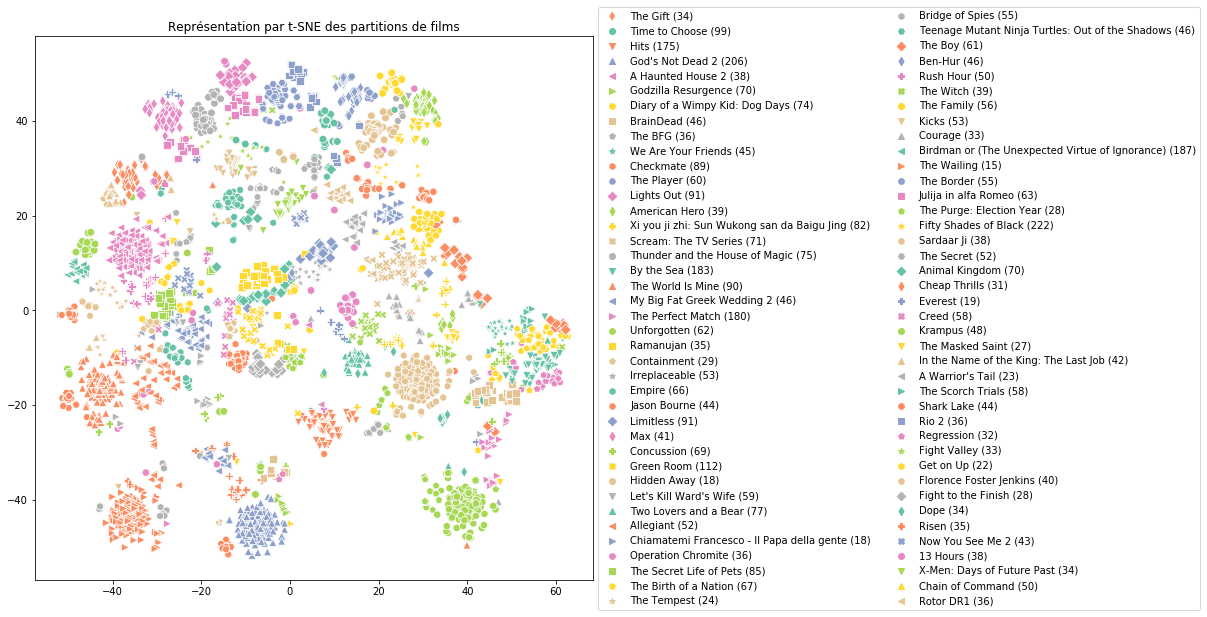

In [50]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', 
           '*', 'h', 'H', 'D', 'd', 'P', 'X']
markers_map = { i: markers[i % len(markers)] for i in range(0, n_clusters)}
palette = np.array(sns.color_palette("hls", n_clusters))
fig, axis = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tsne_results[:, 0], 
                y=tsne_results[:, 1],                 
                s=60, 
                ax=axis,                     
                style=categories,           
                hue=categories,
                palette=sns.color_palette("Set2", n_clusters),
                markers=markers_map,
                legend="full")\
   .set_title('Représentation par t-SNE des partitions de films');
axis.legend(names, loc='center left', bbox_to_anchor=(1, 0, 1, 1), ncol=2);